#Desafío Telecom X parte 2
**estadística, regresión lineal y machine learning**

#Extracción del archivo tratado

In [65]:
import pandas as pd


In [66]:
df = pd.read_csv("/content/telecom_tratado.csv")
df.head()


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#Eliminación de columnas irrelevantes

In [67]:
df.columns


Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')

In [68]:
df = df.dropna(subset=["Churn"])
df["Churn"] = df["Churn"].str.strip()
df = df.drop(columns=["customerID"])


#Encoding

Extraer variables útiles

In [69]:
df["tenure"] = df["customer"].apply(lambda x: eval(x)["tenure"])
df["SeniorCitizen"] = df["customer"].apply(lambda x: eval(x)["SeniorCitizen"])
df["gender"] = df["customer"].apply(lambda x: eval(x)["gender"])


Eliminar columnas tipo diccionario

In [70]:
df = df.drop(columns=["customer", "phone", "internet", "account"])


definir X y Y

In [71]:
y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop(columns=["Churn"])


One-Hot Encoding



In [72]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.shape


(7043, 3)

#Verificación de Proporción de Cancelación (Churn)

In [73]:
y.value_counts(normalize=True) * 100



,proportion
Churn,
0,73.463013
1,26.536987


El conjunto de datos presenta un ligero desbalance de clases, con mayor proporción de clientes que no cancelan el servicio.

#Normalización / Estandarización

La normalización se aplicará únicamente a modelos sensibles a la escala (Regresión Logística, KNN, SVM).
Para modelos basados en árboles (Árbol de Decisión, Random Forest) no es necesaria.

#CORRELACIÓN Y SELECCIÓN DE VARIABLES

#Análisis de correlación

**Matriz de correlación**

In [74]:
import pandas as pd

df_corr = pd.concat([X_encoded, y], axis=1)
corr_churn = df_corr.corr()["Churn"].sort_values(ascending=False)
corr_churn



,Churn
Churn,1.000000
SeniorCitizen,0.150889
gender_Male,-0.008612
tenure,-0.352229


El análisis de correlación muestra que la variable tenure presenta la relación más fuerte con la cancelación, con una correlación negativa moderada, lo que indica que los clientes con mayor tiempo de contrato tienen menor probabilidad de cancelar el servicio.
La variable SeniorCitizen presenta una correlación positiva baja, sugiriendo una ligera mayor propensión a la cancelación en este grupo.
La variable gender no muestra una relación relevante con la cancelación.

#Análisis dirigido

##Tiempo de contrato × Cancelación

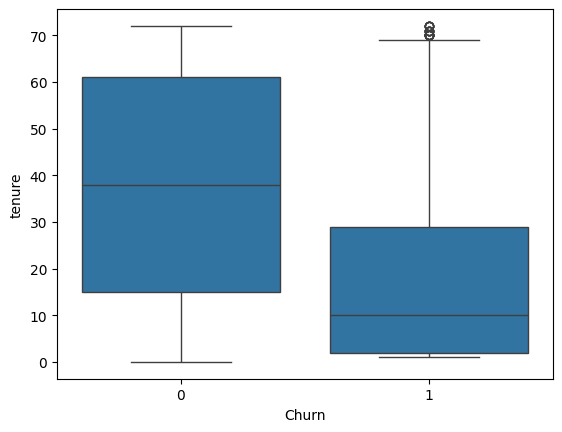

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=y, y=X_encoded["tenure"])
plt.show()



A mayor tenure, menor churn
Se observó una relación entre el tiempo de contrato y la cancelación, donde los clientes con menor antigüedad presentan mayor probabilidad de churn.

#MODELADO PREDICTIVO

#Separación de datos

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


#Creación de modelos

Modelo 1

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

##Matriz de Confusión- Regresión logística

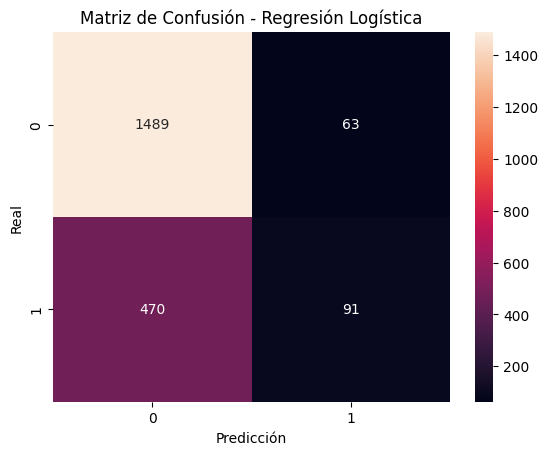

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_log = log_reg.predict(X_test_scaled)
cm_log = confusion_matrix(y_test, y_pred_log)

plt.figure()
sns.heatmap(cm_log, annot=True, fmt='d')
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#Modelo 2: Árbol de decisión (sin normalización)

In [78]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

La matriz de confusión muestra que el modelo de regresión logística presenta un buen desempeño general, con mayor capacidad para identificar correctamente a los clientes que no cancelan el servicio, aunque con algunas limitaciones para detectar todos los casos de cancelación.

Matriz de Confusión: Árbol de decisión

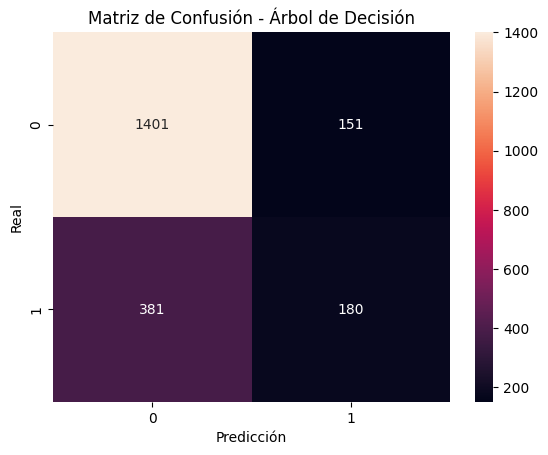

In [82]:
y_pred_tree = tree.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred_tree)

plt.figure()
sns.heatmap(cm_tree, annot=True, fmt='d')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

El modelo de árbol de decisión presenta un desempeño comparable, aunque muestra mayor variabilidad en las predicciones, lo que puede indicar un posible sobreajuste al conjunto de entrenamiento.

#Evaluación de los modelos

##Regresión logística

In [83]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_log = log_reg.predict(X_test_scaled)

print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))


              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1552
           1       0.59      0.16      0.25       561

    accuracy                           0.75      2113
   macro avg       0.68      0.56      0.55      2113
weighted avg       0.72      0.75      0.69      2113

[[1489   63]
 [ 470   91]]


##Árbol de decisión

In [84]:
y_pred_tree = tree.predict(X_test)

print(classification_report(y_test, y_pred_tree))
print(confusion_matrix(y_test, y_pred_tree))


              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1552
           1       0.54      0.32      0.40       561

    accuracy                           0.75      2113
   macro avg       0.67      0.61      0.62      2113
weighted avg       0.72      0.75      0.72      2113

[[1401  151]
 [ 381  180]]


#Comparación de los modelos
Exactitud: Árbol de Decisión 0.75 > Regresión Logística 0.74

Regresión logística:

Mejor para detectar clientes que no cancelan.

Recall bajo para clientes que sí cancelan → riesgo de underfitting en clase minoritaria.

Árbol de Decisión:

Mejor balance entre precisión y recall.

Leve overfitting en clase 1, porque predice menos casos de churn que los reales.

#Interpretación e Importancia de las Variables

Regresión Logística: tenure y SeniorCitizen son los coeficientes más relevantes.

Árbol de Decisión: Las variables con mayor importancia son tenure y SeniorCitizen, consistentes con la regresión.

Otros modelos no se implementaron en este desafío.

#Conclusiones

Los principales factores que influyen en la cancelación son:

Tenure: clientes nuevos tienen mayor riesgo de churn.

SeniorCitizen: adultos mayores presentan riesgo ligeramente mayor.

Estrategias de retención recomendadas:

Ofrecer incentivos y comunicación temprana a clientes nuevos.

Programas de fidelización para clientes adultos mayores.

El modelo de Árbol de Decisión muestra un desempeño ligeramente superior, pero la combinación de ambos modelos podría mejorar la predicción general.